# Sample Weights

In [4]:
#%load_ext watermark
#%watermark

%load_ext autoreload
%autoreload 2

# import standard libs
from IPython.display import display
#from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'


# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import ffn

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from utils import cprint
from bars import *

RANDOM_STATE = 777

print()
#%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Code Snippets

Below I reproduce all the relevant code snippets found in the book that are necessary to work through the excercises found at the end of chapter 3.

In [5]:
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

### Symmetric CUSUM Filter [2.5.2.1]

In [6]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()#.abs()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

### Daily Volatility Estimator [3.1]

In [7]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

### Triple-Barrier Labeling Method [3.2]

In [8]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

### Gettting Time of First Touch (getEvents) [3.3], [3.6]

In [9]:
#Calcola, in base ai parametri passati, il target e la data in cui viene raggiunto
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_,ptSl_= pd.Series(1.,index=trgt.index), [ptSl[0], ptSl[0]]
    else: 
        side_,ptSl_= side.loc[trgt.index], ptSl[:2]

    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    
    if side is None:
        events=events.drop('side',axis=1)
    
    return events

### Adding Vertical Barrier [3.4]

In [10]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

### Labeling for side and size [3.5]

In [11]:
def getBinsOld(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out

### Expanding getBins to Incorporate Meta-Labeling [3.7]

In [12]:
# In base alla data di inizio e di raggiungimento del target determina il ritorno in termini
# percentuali e assegna l'etichetta
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

### Dropping Unnecessary Labels [3.8]

In [13]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

### Linear Partitions [20.4.1]

In [14]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [15]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

### multiprocessing snippet [20.7]

In [16]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

### single-thread execution for debugging [20.8]

In [17]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

### Example of async call to multiprocessing lib [20.9]

In [18]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

### Unwrapping the Callback [20.10]

In [19]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

### Pickle Unpickling Objects [20.11]

In [20]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
import copyreg,types, multiprocessing as mp
copyreg.pickle(types.MethodType,_pickle_method,_unpickle_method)

### Estimating uniqueness of a label [4.1]

In [21]:
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Compute the number of concurrent events per bar
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count
    '''
    #1) Find any events that span the period molecule[0] molecule[-1]
    t1 = t1.fillna(closeIdx[-1])
    t1 = t1[t1 >= molecule[0]]
    t1 = t1.loc[:t1[molecule].max()]
    #2) Count events spanning the bar
    iloc = closeIdx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=closeIdx[iloc[0]:iloc[-1]+1])
    for tIn, tOut in t1.iteritems():
        count.loc[tIn:tOut] += 1
    return count.loc[molecule[0]:t1[molecule].max()]

# Exercises

## Import Dataset

Note this dataset below has been resampled to `1s` and then `NaNs` removed. This was done to remove any duplicate indices not accounted for in a simple call to `pd.DataFrame.drop_duplicates()`. 

In [22]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
#infp = PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v         dv
dates                                                             
2018-09-04 15:59:55  115.93  115.92  115.93   803   803   93091.79
2018-09-04 15:59:56  115.92  115.91  115.92   155   155   17967.60
2018-09-04 16:00:00  115.92  115.91  115.92  8570  8570  993434.40
2018-09-04 16:10:00  115.92  114.46  117.06     0     0       0.00
2018-09-04 18:30:00  115.92  115.35  116.57     0     0       0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1010793 entries, 2009-09-28 09:30:00 to 2018-09-04 18:30:00
Data columns (total 6 columns):
price    1010793 non-null float64
bid      1010793 non-null float64
ask      1010793 non-null float64
size     1010793 non-null int64
v        1010793 no

In [23]:
df = df[~df.index.duplicated(keep='last')]

## Excercise [4.1.a]
- Compute a "t1" series on dollar bars
  1. Compute dollar bars
  2. Compute daily volatility
  3. Compute vertical barriers
  4. Compute 't1'

### Excercise [4.1.a.1] Compute dollar bars

In [24]:
dbars = dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
cprint(dbars)
#dbars = df

100%|██████████| 1010793/1010793 [00:00<00:00, 2502312.58it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask  size     v           dv
dates                                                                 
2018-09-04 15:21:31  115.8437  115.84  115.85   888   888  102869.2056
2018-09-04 15:30:57  115.8200  115.82  115.83   299   299   34630.1800
2018-09-04 15:43:51  115.7721  115.77  115.78   370   370   42835.6770
2018-09-04 15:55:27  115.7500  115.74  115.75  1300  1300  150475.0000
2018-09-04 15:59:56  115.9200  115.91  115.92   155   155   17967.6000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34419 entries, 2009-09-28 09:53:49 to 2018-09-04 15:59:56
Data columns (total 6 columns):
price    34419 non-null float64
bid      34419 non-null float64
ask      34419 non-null float64
size     34419 non-null int64
v

### Excercise [4.1.a.2] Compute daily volatility

In [25]:
close = dbars.price.copy()
dailyVol = getDailyVol(close)
cprint(dailyVol.to_frame())

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
dates                        
2018-09-04 15:21:31  0.003593
2018-09-04 15:30:57  0.003557
2018-09-04 15:43:51  0.003523
2018-09-04 15:55:27  0.003489
2018-09-04 15:59:56  0.003456
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34402 entries, 2009-09-29 10:10:51 to 2018-09-04 15:59:56
Data columns (total 1 columns):
dailyVol    34401 non-null float64
dtypes: float64(1)
memory usage: 537.5 KB
None
-------------------------------------------------------------------------------



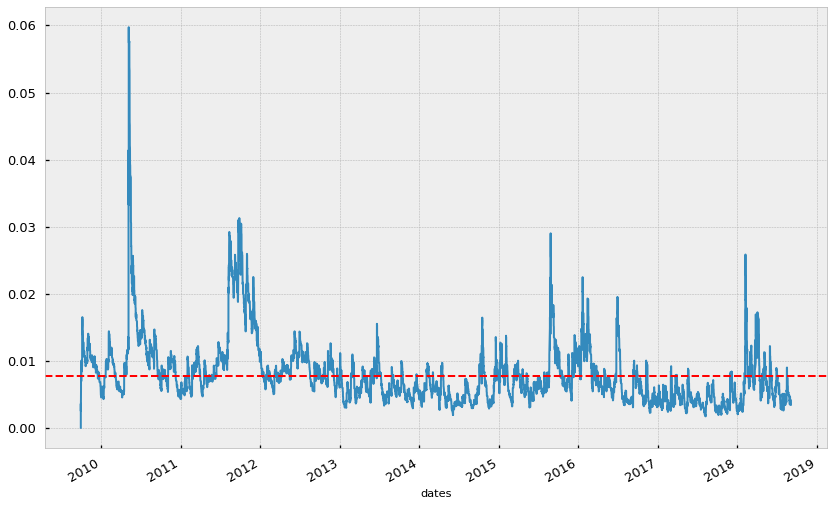

In [26]:
plt.figure(figsize=(14, 9))
#f,ax=plt.subplots()
dailyVol.plot()
plt.axhline(dailyVol.mean(),ls='--',color='red')
plt.show()

### Excercise [4.1.a.3] Compute TEvents, Vertical Barriers and _*t1*_

In [27]:
tEvents = getTEvents(close, h=dailyVol.mean())
tEvents

100%|██████████| 34417/34417 [00:03<00:00, 10553.05it/s]


DatetimeIndex(['2009-09-29 09:41:11', '2009-09-30 09:45:10',
               '2009-09-30 13:27:29', '2009-10-01 09:37:39',
               '2009-10-01 11:54:41', '2009-10-01 15:59:13',
               '2009-10-01 16:16:36', '2009-10-02 09:43:09',
               '2009-10-02 10:35:08', '2009-10-05 09:58:50',
               ...
               '2018-08-10 09:30:00', '2018-08-13 13:12:33',
               '2018-08-14 10:55:15', '2018-08-15 09:50:42',
               '2018-08-16 09:35:45', '2018-08-17 12:17:18',
               '2018-08-21 09:30:00', '2018-08-23 09:45:02',
               '2018-08-27 09:33:40', '2018-08-30 15:06:41'],
              dtype='datetime64[ns]', length=2413, freq=None)

In [28]:
# compute start and end of each triple barrier
t1 = addVerticalBarrier(tEvents, close)
#t1

In [29]:
# create target series
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01
# get cpu count - 1
cpus = cpu_count() - 1
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)

2018-10-13 18:04:36.686761 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


In [30]:
cprint(events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2018-04-10 15:10:14 2018-04-11 15:16:22  0.010773
2018-04-11 09:30:02 2018-04-12 09:39:50  0.010328
2018-05-04 13:35:12 2018-05-07 09:30:00  0.010548
2018-05-31 10:52:48 2018-06-01 11:26:50  0.011713
2018-06-01 10:01:14 2018-06-04 09:32:00  0.010680
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 2 columns):
t1      944 non-null datetime64[ns]
trgt    944 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.1 KB
None
-------------------------------------------------------------------------------



## Excercise [4.1.b]
- Apply the function mpNumCoEvents() to compute the number of overlapping outcomes at each point in time

In [31]:
#close[events.index]
coEvents = mpNumCoEvents(closeIdx=events.index, t1=events.t1, molecule=events.index)

count    944.000000
mean       2.757415
std        1.432633
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       12.000000
dtype: float64


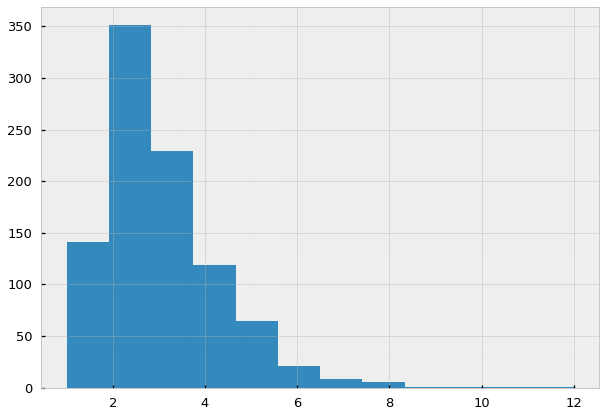

In [32]:
print(coEvents.describe())
plt.hist(coEvents, bins=12)
plt.show()

## Excercise [4.1.c]
- Plot the time series of the number of concurrent labels on the primary axis, and the time series of the exponentially moving standard deviation of returns on the secondary axis

In [33]:
cprint(coEvents)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
2018-04-10 15:10:14  4
2018-04-11 09:30:02  4
2018-05-04 13:35:12  1
2018-05-31 10:52:48  1
2018-06-01 10:01:14  2
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 1 columns):
0    944 non-null int64
dtypes: int64(1)
memory usage: 14.8 KB
None
-------------------------------------------------------------------------------



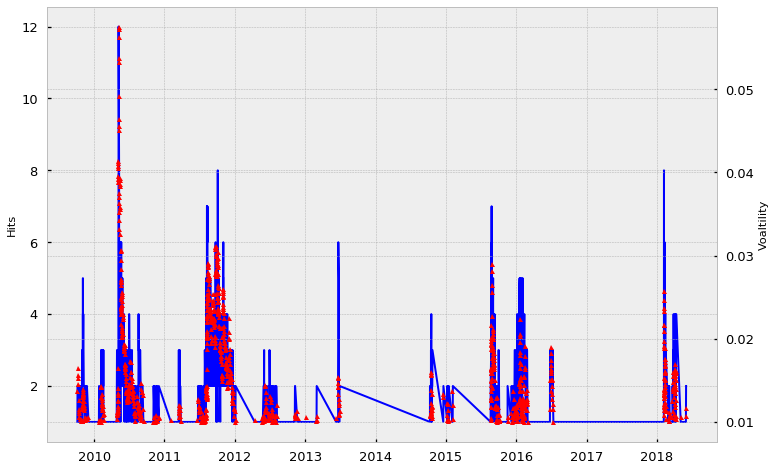

In [51]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(coEvents.index, coEvents.values, 'b-')
ax1.set_ylabel('Hits')
ax2 = ax1.twinx()
ax2.set_ylabel('Voaltility')
ax2.plot(dailyVol[coEvents.index].index, dailyVol[coEvents.index].values, color='red', ls='', marker='^', markersize=5)

[]

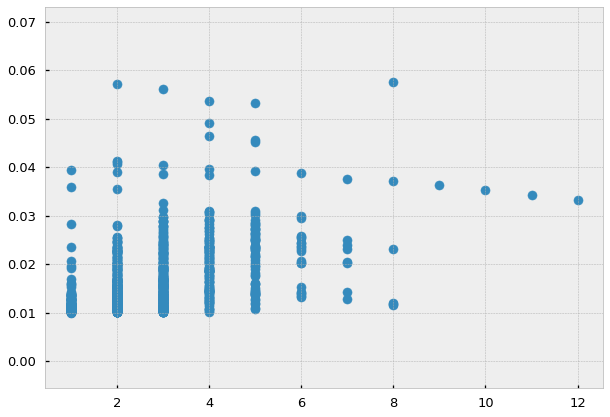

In [52]:
#coEvents.shape, dailyVol[coEvents.index].shape
plt.scatter(coEvents.values, dailyVol[coEvents.index].values)
plt.plot()

## Excercise [4.2]
Using function "mpSampleTW", compute the average uniqueness of each label. 
What is the first order serial correlation, AR(1), of this time series?
Is it statistically significant? Why?

In [53]:
def mpSampleTW(t1, numCoEvents, molecule):
    # Derive average uniqueness over the event's lifespan
    wght = pd.Series(index=molecule)
    for tIn, tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn] = (1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [54]:
numCoEvents_ = mpSampleTW(t1=events.t1, numCoEvents=coEvents, molecule=events.index)
numCoEvents_.shape

(944,)

In [55]:
numThreads = cpu_count() - 1
#numCoEvents = mpPandasObj(mpNumCoEvents, ('molecule', events.index), numThreads=numThreads,\
#                          closeIdx=events.index, t1=events.t1)

numCoEvents = coEvents.loc[~coEvents.index.duplicated(keep='last')]
#numCoEvents = numCoEvents.reindex(close.index).fillna(0)
numCoEvents = mpPandasObj(mpSampleTW, ('molecule', events.index), numThreads, t1=events.t1, numCoEvents=numCoEvents)
numCoEvents.shape

2018-10-13 18:53:41.493637 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.


(944,)

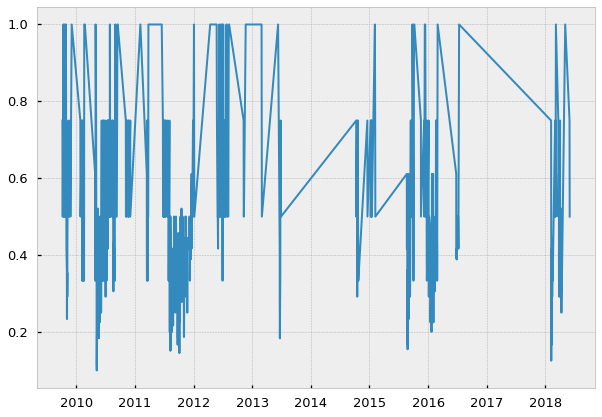

In [63]:
plt.plot(numCoEvents)
plt.show()

In [84]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

#np.corrcoef(numCoEvents.values[:-1], numCoEvents.values[1:])
acf(numCoEvents.values, length=2)[1]

0.6604516741150607

### It seems that there is a strong positive autocorrelation of order 1

In [56]:
# check whether results of two computations are the same
print(np.sum(numCoEvents_-numCoEvents))
numCoEvents[numCoEvents > numCoEvents.mean()].shape

0.0


(356,)

In [57]:
def getIndMatrix(barIdx, t1):
    # get indicator matrix
    indM = pd.DataFrame(0, index=barIdx, columns=range(t1.shape[0]))
    #print(t1.shape[0])
    for i, (t0, t1) in enumerate(tqdm(t1.iteritems())):
        #print(i, t0, t1)
        indM.loc[t0:t1, i] = 1
    return indM

In [39]:
indM = getIndMatrix(close.index, events.t1)

1it [00:00,  1.24it/s]

944


944it [12:03,  1.31it/s]


In [54]:
if(indM is not None):
    # Due to long computation, about 10 minutes on my machine, 
    # save DataFrame in file changing columns type
    indM_2 = indM.copy()
    indM_2 = indM_2.rename(str, axis='columns')
    infp = PurePath(data_dir/'processed'/'indM.parquet')
    #infp = PurePath(data_dir/'interim'/'IVE_tickbidask.parq')
    indM_2.to_parquet(infp)
#cprint(df)

In [114]:
# Restore indM from file
infp = PurePath(data_dir/'processed'/'indM.parquet')
indM = pd.read_parquet(infp)
indM = indM.rename(int, axis='columns')

In [117]:
indM.head()

,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
dates,,,,,,,,,,,,,,,,,,,,,
2009-09-28 09:53:49,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-09-28 10:06:18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-09-28 10:23:06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-09-28 10:39:55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-09-28 11:00:40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
def getAverageUniqueness(indM):
    #Average uniqueness from indicator matrix
    c = indM.sum(axis=1) #concurrency
    u = indM.div(c, axis=0) #uniqueness
    avgU = u[u>0].mean() #average uniqueness
    return avgU

In [119]:
avgU = getAverageUniqueness(indM)
avgU

0      0.875000
1      0.636364
2      0.500000
3      0.650000
4      0.863636
5      1.000000
6      0.928571
7      0.821429
8      0.818182
9      0.863636
10     0.500000
11     1.000000
12     0.772727
13     0.687500
14     1.000000
15     0.750000
16     0.714286
17     0.683333
18     0.472222
19     0.479167
20     0.537037
21     0.444444
22     0.661111
23     0.272222
24     0.248333
25     0.266667
26     0.233333
27     0.212500
28     0.275926
29     0.379630
30     0.684524
31     0.371212
32     0.312500
33     0.375000
34     0.583333
35     0.700000
36     0.642857
37     0.541667
38     0.590909
39     0.900000
40     0.954545
41     0.833333
42     0.916667
43     0.944444
44     0.944444
45     0.966667
46     1.000000
47     0.833333
48     0.833333
49     0.928571
         ...   
894    0.373810
895    0.522727
896    0.564516
897    0.474359
898    0.432292
899    0.387097
900    0.341270
901    0.637681
902    0.652174
903    0.578947
904    0.916667
905    0

In [113]:
for i in tqdm(range(0, 10)): print(i)




  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 7106.58it/s]

0
1
2
3
4
5
6
7
8
9


In [111]:
def seqBootstrap(indM, sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None : 
        sLength = indM.shape[1]
    phi = []
    _range = range(0, sLength)
    for i in tqdm(_range):
    #while len(phi) < sLength:
        #print(len(phi), sLength, '>>>', phi)
        avgU = pd.Series()
        for i in indM:
            indM_ = indM[phi+[i]] # reduce indM
            avgU.loc[i] = getAverageUniqueness(indM_).iloc[-1]
        prob = avgU/avgU.sum() # draw probability
        phi += [np.random.choice(indM.columns, p=prob)]
    return phi

In [44]:
#phi = seqBootstrap(indM, 5)

0 5 >>> []
1 5 >>> [149]
2 5 >>> [149, 280]
3 5 >>> [149, 280, 141]
4 5 >>> [149, 280, 141, 755]


In [112]:
#t1 = events.t1

#barIx = range(t1.max()+1)
#indM = getIndMatrix(barIx, t1)

#phi = np.random.choice(indM.columns, size=indM.shape[1])
#print(phi)
#print('Standard Uniqueness',getAverageUniqueness(indM[phi]).mean())

#phi = seqBootstrap(indM)
phi=[234, 452, 12, 345]
indM[phi]
#print(phi)
print('Standard Uniqueness',getAverageUniqueness(indM[phi]).mean())



  0%|          | 0/944 [00:00<?, ?it/s]

  0%|          | 1/944 [00:03<1:02:34,  3.98s/it]

  0%|          | 2/944 [00:10<1:20:41,  5.14s/it]

  0%|          | 3/944 [00:17<1:30:21,  5.76s/it]

  0%|          | 4/944 [00:25<1:38:41,  6.30s/it]

KeyboardInterrupt: 

In [41]:
events_ = events.dropna(subset=['t1'])
print(events.shape, events_.shape)
px = events_.index.union(events_['t1'].values).drop_duplicates()
px = close.reindex(px, method='bfill')
out  = pd.DataFrame(index=events_.index)
out['ret'] = px.loc[events_['t1'].values].values/px.loc[events_.index.values].values - 1
if 'side' in events_: out['ret'] *= events_['side']

out['bin'] = np.sign(out['ret'])

if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0 #meta-labeling
    
cprint(out)

(944, 2) (944, 2)
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-04-10 15:10:14 -0.009586 -1.0
2018-04-11 09:30:02  0.007678  1.0
2018-05-04 13:35:12  0.003480  1.0
2018-05-31 10:52:48  0.005233  1.0
2018-06-01 10:01:14  0.002968  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 2 columns):
ret    944 non-null float64
bin    944 non-null float64
dtypes: float64(2)
memory usage: 62.1 KB
None
-------------------------------------------------------------------------------



### (d) Apply `getBins` to generate labels

In [28]:
labels = getBins(events, close)
cprint(labels)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-04-10 15:10:14 -0.009586 -1.0
2018-04-11 09:30:02  0.007678  1.0
2018-05-04 13:35:12  0.003480  1.0
2018-05-31 10:52:48  0.005233  1.0
2018-06-01 10:01:14  0.002968  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 2 columns):
ret    944 non-null float64
bin    944 non-null float64
dtypes: float64(2)
memory usage: 62.1 KB
None
-------------------------------------------------------------------------------



In [29]:
labels.bin.value_counts()

 1.0    543
-1.0    399
 0.0      2
Name: bin, dtype: int64

## [3.2] Use snippet 3.8 to drop under-populated labels

In [30]:
clean_labels = dropLabels(labels)
cprint(clean_labels)

dropped label:  0.0 0.00211864406779661
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-04-10 15:10:14 -0.009586 -1.0
2018-04-11 09:30:02  0.007678  1.0
2018-05-04 13:35:12  0.003480  1.0
2018-05-31 10:52:48  0.005233  1.0
2018-06-01 10:01:14  0.002968  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 2 columns):
ret    942 non-null float64
bin    942 non-null float64
dtypes: float64(2)
memory usage: 22.1 KB
None
-------------------------------------------------------------------------------



In [31]:
clean_labels.bin.value_counts()

 1.0    543
-1.0    399
Name: bin, dtype: int64

## [3.4] Develop moving average crossover strategy. For each obs. the model suggests a side but not size of the bet

In [32]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
cprint(close_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price        fast        slow
dates                                                
2018-09-04 15:21:31  115.8437  115.838962  115.825157
2018-09-04 15:30:57  115.8200  115.834221  115.824513
2018-09-04 15:43:51  115.7721  115.818691  115.817961
2018-09-04 15:55:27  115.7500  115.801518  115.809466
2018-09-04 15:59:56  115.9200  115.831139  115.823283
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34419 entries, 2009-09-28 09:53:49 to 2018-09-04 15:59:56
Data columns (total 3 columns):
price    34419 non-null float64
fast     34419 non-null float64
slow     34419 non-null float64
dtypes: float64(3)
memory usage: 1.1 MB
None
-------------------------------------------------------------------------------



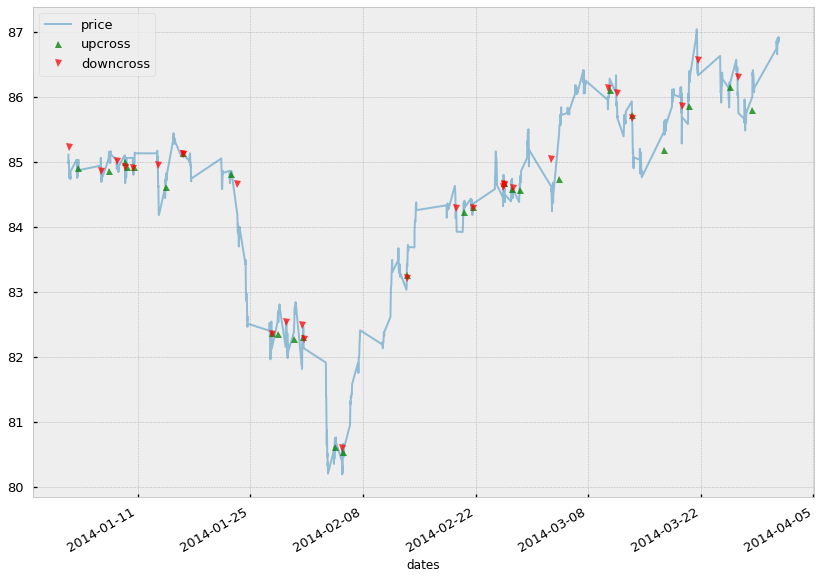

In [34]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(14,10))
from_date, to_date = '2014-01', '2014-03'
close_df.price.loc[from_date:to_date].plot(ax=ax, alpha=.5)

up.loc[from_date:to_date].plot(ax=ax, ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc[from_date:to_date].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

### (a) Derive meta-labels for `ptSl = [1,2]` and `t1` where `numdays=1`. Use as `trgt` dailyVol computed by snippet 3.1 (get events with sides)

In [35]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2018-09-04 10:59:06  1
2018-09-04 11:24:49 -1
2018-09-04 14:52:41  1
2018-09-04 15:55:27 -1
2018-09-04 15:59:56  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2009-09-30 09:45:10 to 2018-09-04 15:59:56
Data columns (total 1 columns):
0    1916 non-null int64
dtypes: int64(1)
memory usage: 29.9 KB
None
-------------------------------------------------------------------------------



In [36]:
minRet = .01 
ptsl=[1,2]
ma_events = getEvents(close, tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)
cprint(ma_events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2018-04-10 15:10:14   NaN 2018-04-11 15:16:22  0.010773
2018-04-11 09:30:02  -1.0 2018-04-12 09:39:50  0.010328
2018-05-04 13:35:12   NaN 2018-05-07 09:30:00  0.010548
2018-05-31 10:52:48   NaN 2018-06-01 11:26:50  0.011713
2018-06-01 10:01:14   1.0 2018-06-04 09:32:00  0.010680
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 3 columns):
side    109 non-null float64
t1      944 non-null datetime64[ns]
trgt    944 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 29.5 KB
None
-------------------------------------------------------------------------------



2018-10-02 19:59:49.365571 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


In [37]:
ma_events.side.value_counts()

-1.0    56
 1.0    53
Name: side, dtype: int64

In [38]:
ma_side = ma_events.dropna().side
ma_side.head()

2009-10-23 11:16:42   -1.0
2009-10-30 11:52:10   -1.0
2009-11-02 12:23:30   -1.0
2009-11-16 10:03:48    1.0
2009-11-23 09:37:23    1.0
Name: side, dtype: float64

In [39]:
ma_bins = getBins(ma_events,close).dropna()
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-04-02 10:00:27  0.011588  1.0
2018-04-04 09:39:19 -0.026034  0.0
2018-04-06 09:39:07  0.013363  1.0
2018-04-11 09:30:02 -0.007678  0.0
2018-06-01 10:01:14  0.002968  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 2009-10-23 11:16:42 to 2018-06-01 10:01:14
Data columns (total 2 columns):
ret    109 non-null float64
bin    109 non-null float64
dtypes: float64(2)
memory usage: 2.6 KB
None
-------------------------------------------------------------------------------



In [40]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
cprint(Xx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin  side
2018-04-02 10:00:27  0.011588  1.0    -1
2018-04-04 09:39:19 -0.026034  0.0    -1
2018-04-06 09:39:07  0.013363  1.0    -1
2018-04-11 09:30:02 -0.007678  0.0    -1
2018-06-01 10:01:14  0.002968  1.0     1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 2009-10-23 11:16:42 to 2018-06-01 10:01:14
Data columns (total 3 columns):
ret     109 non-null float64
bin     109 non-null float64
side    109 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.4 KB
None
-------------------------------------------------------------------------------



### (b) Train Random Forest to decide whether to trade or not `{0,1}` since underlying model (crossing m.a.) has decided the side, `{-1,1}`

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [52]:
X = ma_side.values.reshape(-1,1)
#X = Xx.side.values.reshape(-1,1)
y = ma_bins.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
ma_bins.head()
#X_train[0:10], y_train[0:10]

,ret,bin
2009-10-23 11:16:42,0.003676,1.0
2009-10-30 11:52:10,0.016200,1.0
2009-11-02 12:23:30,0.001107,1.0
2009-11-16 10:03:48,-0.003403,0.0
2009-11-23 09:37:23,-0.005986,0.0


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        26
        1.0       0.53      1.00      0.69        29

avg / total       0.28      0.53      0.36        55



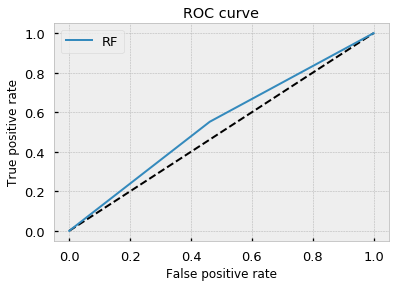

In [46]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## [3.5] Develop mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

In [47]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [48]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
cprint(bb_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price      ave    upper    lower
dates                                                   
2018-09-04 15:21:31  115.8437  115.960  116.182  115.737
2018-09-04 15:30:57  115.8200  115.950  116.169  115.732
2018-09-04 15:43:51  115.7721  115.940  116.155  115.725
2018-09-04 15:55:27  115.7500  115.930  116.140  115.719
2018-09-04 15:59:56  115.9200  115.922  116.126  115.718
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34370 entries, 2009-10-01 15:27:48 to 2018-09-04 15:59:56
Data columns (total 4 columns):
price    34370 non-null float64
ave      34370 non-null float64
upper    34370 non-null float64
lower    34370 non-null float64
dtypes: float64(4)
memory usage: 1.3 MB
None
----------------------------------------------------

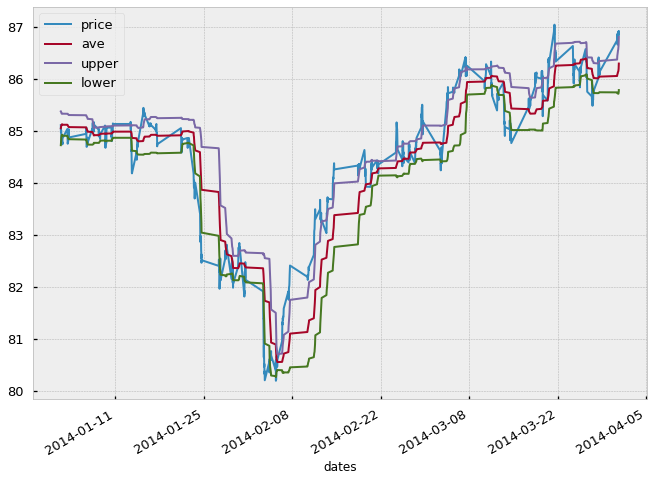

In [50]:
f,ax=plt.subplots(figsize=(11,8))
bb_df.loc[from_date:to_date].plot(ax=ax)

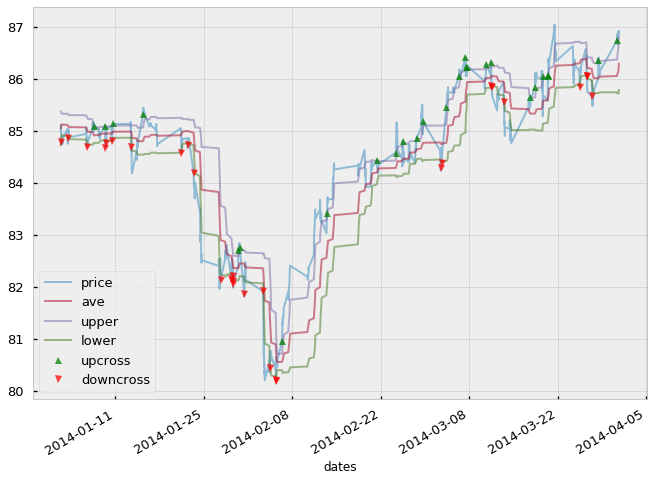

In [51]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc[from_date:to_date].plot(ax=ax, alpha=.5)
bb_up.loc[from_date:to_date].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc[from_date:to_date].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()

### (a) Derive meta-labels for `ptSl=[0,2]` and `t1` where `numdays=1`. Use as `trgt` dailyVol.

In [53]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
cprint(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
cprint(bb_events)

bb_side = bb_events.dropna().side
cprint(bb_side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2018-08-30 14:13:35  1
2018-08-31 15:30:49  1
2018-09-04 09:40:32  1
2018-09-04 11:24:49  1
2018-09-04 13:44:54  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2199 entries, 2009-10-06 10:13:09 to 2018-09-04 13:44:54
Data columns (total 1 columns):
0    2199 non-null int64
dtypes: int64(1)
memory usage: 34.4 KB
None
-------------------------------------------------------------------------------



2018-10-02 20:04:35.474122 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2018-04-10 15:10:14   NaN 2018-04-11 15:16:22  0.010773
2018-04-11 09:30:02   NaN 2018-04-12 09:39:50  0.010328
2018-05-04 13:35:12   NaN 2018-05-07 09:30:00  0.010548
2018-05-31 10:52:48   NaN 2018-06-01 11:26:50  0.011713
2018-06-01 10:01:14  -1.0 2018-06-04 09:32:00  0.010680
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 3 columns):
side    135 non-null float64
t1      944 non-null datetime64[ns]
trgt    944 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 29.5 KB
None
-------------------------------------------------------------------------------

--------------------------------------------------

In [54]:
bb_side.value_counts()

 1.0    69
-1.0    66
Name: side, dtype: int64

In [55]:
bb_bins = getBins(bb_events,close).dropna()
cprint(bb_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-02-13 13:43:21 -0.010096  0.0
2018-02-14 10:30:48 -0.010876  0.0
2018-04-02 10:56:50 -0.002041  0.0
2018-04-10 09:42:37  0.001364  1.0
2018-06-01 10:01:14 -0.002968  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135 entries, 2009-10-06 10:13:09 to 2018-06-01 10:01:14
Data columns (total 2 columns):
ret    135 non-null float64
bin    135 non-null float64
dtypes: float64(2)
memory usage: 3.2 KB
None
-------------------------------------------------------------------------------



In [56]:
bb_bins.bin.value_counts()

0.0    73
1.0    62
Name: bin, dtype: int64

### (b) train random forest to decide to trade or not. Use features: volatility, serial correlation, and the crossing moving averages from exercise 2.

In [57]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()

In [58]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
cprint(srl_corr)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     srl_corr
dates                        
2018-09-04 15:21:31 -0.084969
2018-09-04 15:30:57 -0.083904
2018-09-04 15:43:51 -0.083574
2018-09-04 15:55:27 -0.082566
2018-09-04 15:59:56 -0.083957
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34418 entries, 2009-09-28 10:06:18 to 2018-09-04 15:59:56
Data columns (total 1 columns):
srl_corr    34368 non-null float64
dtypes: float64(1)
memory usage: 537.8 KB
None
-------------------------------------------------------------------------------



In [59]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr
2018-04-02 10:00:27  0.010454     -1.0 -0.031262
2018-04-04 09:39:19  0.016912     -1.0  0.295663
2018-04-06 09:39:07  0.012194     -1.0 -0.060165
2018-04-11 09:30:02  0.010328     -1.0 -0.064287
2018-06-01 10:01:14  0.010680      1.0 -0.110693
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 2009-10-23 11:16:42 to 2018-06-01 10:01:14
Data columns (total 3 columns):
vol         109 non-null float64
ma_side     109 non-null float64
srl_corr    109 non-null float64
dtypes: float64(3)
memory usage: 3.4 KB
None
-------------------------------------------------------------------------------



In [60]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          vol  ma_side  srl_corr  bin
2018-04-02 10:00:27  0.010454     -1.0 -0.031262  0.0
2018-04-04 09:39:19  0.016912     -1.0  0.295663  1.0
2018-04-06 09:39:07  0.012194     -1.0 -0.060165  1.0
2018-04-11 09:30:02  0.010328     -1.0 -0.064287  0.0
2018-06-01 10:01:14  0.010680      1.0 -0.110693  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 2009-10-23 11:16:42 to 2018-06-01 10:01:14
Data columns (total 4 columns):
vol         109 non-null float64
ma_side     109 non-null float64
srl_corr    109 non-null float64
bin         109 non-null float64
dtypes: float64(4)
memory usage: 4.3 KB
None
-------------------------------------------------------------------------------



In [61]:
Xy.bin.value_counts()

0.0    62
1.0    47
Name: bin, dtype: int64

In [62]:
X = Xy.drop('bin',axis=1).values
print(X[0:3])
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

[[ 0.01012805 -1.          0.22606702]
 [ 0.01165233 -1.         -0.01162458]
 [ 0.01395858 -1.          0.00553777]]


             precision    recall  f1-score   support

   no_trade       0.71      0.53      0.61        32
      trade       0.52      0.70      0.59        23

avg / total       0.63      0.60      0.60        55



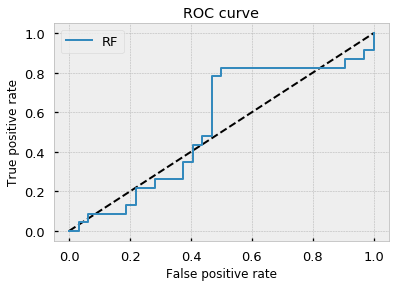

In [64]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### (c) What is accuracy of predictions from primary model if the secondary model does not filter bets? What is classification report?

2018-10-02 20:08:22.998487 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2018-04-10 15:10:14 2018-04-11 15:16:22  0.010773
2018-04-11 09:30:02 2018-04-12 09:39:50  0.010328
2018-05-04 13:35:12 2018-05-07 09:30:00  0.010548
2018-05-31 10:52:48 2018-06-01 11:26:50  0.011713
2018-06-01 10:01:14 2018-06-04 09:32:00  0.010680
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 944 entries, 2009-10-05 14:59:34 to 2018-06-01 10:01:14
Data columns (total 2 columns):
t1      944 non-null datetime64[ns]
trgt    944 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.1 KB
None
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
dataframe information
-------------

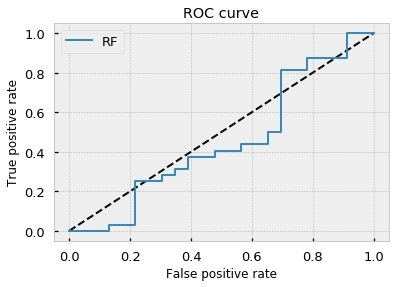

In [65]:
minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
cprint(bb_events)

bb_bins = getBins(bb_events,close).dropna()
cprint(bb_bins)

features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)

Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

### run model ###
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()